In [11]:
import numpy as np
import pandas as pd
import xgboost as xgb
from scipy import stats
import japanize_matplotlib
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

# ===============================================================
# ★★★ オプション設定変数 ★★★
# ===============================================================
GROUP_BY_COURSE = False
GROUP_BY_NUM_HORSES = True

# --- 脚質判定アルゴリズムの選択設定 ---
# "past": 過去の通過順位率の平均値を使用
# "pred": 今回の戦法名(style_name)と指数差による展開予想を使用
STYLE_MODE = "pred" 

# ===============================================================
# 関数定義
# ===============================================================
def confidence_interval(mean: float, std: float, n: int, confidence: float = 0.95):
    t_value = stats.t.ppf((1 + confidence) / 2, df=n-1)
    margin = t_value * std / np.sqrt(n)
    return mean - margin, mean + margin

def handle_missing_val(df, features, enabled, min_horses):
    if not enabled:
        print("⚠ 欠損処理スキップ")
        return df

    print("欠損処理中...")
    processed_groups = []
    for race_id, group in df.groupby("race_id"):
        actual_min_horses = group["num_horses"].iloc[0]
        non_missing_mask = group[features].notnull().all(axis=1)
        if non_missing_mask.sum() < actual_min_horses: 
            continue
        for col in features:
            if group[col].isnull().any():
                group[col] = group[col].fillna(group[col].mean(skipna=True))
        processed_groups.append(group)
    df_processed = pd.concat(processed_groups, ignore_index=True)
    print(f"処理後: {len(df_processed)}件（元:{len(df)}）")
    return df_processed

def get_last_corner_position(row):
    for i in [4, 3, 2, 1]:
        val = row.get(f"position_{i}")
        if pd.notnull(val):
            return val
    return np.nan

def create_dl_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid') 
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ===============================================================
# データ読み込み
# ===============================================================
# target_num_horses = [8, 9, 10, 11, 12]
target_num_horses = [8]
target_course_ids = [
    102, 103, 201, 202, 301, 302, 402,
    501, 502, 601, 602, 700, 702, 802,
    900, 901, 1001, 1002, 1201, 1304, 1400, 1402
]

input_file = "input_全頭_編集後.csv"
df_all = pd.read_csv(input_file, encoding="utf-8")
df_all["race_date"] = pd.to_datetime(df_all["race_date"])
print(f"全データ: {len(df_all)}件")

# 並び替え
df_all = df_all.sort_values(["race_id", "horse_number"])

# ===============================================================
# A. 過去実績ベースの脚質算出 (running_style_type_past)
# ===============================================================
print("🏇 過去実績ベースの脚質を算出中...")
df_all["last_corner_position"] = df_all.apply(get_last_corner_position, axis=1)
df_all["last_corner_position_rate"] = df_all["last_corner_position"] / df_all["num_horses"]

# 時系列順で過去平均を計算
df_all = df_all.sort_values(["horse_id", "race_date"])
df_all["avg_last_corner_pos_rate_past"] = (
    df_all.groupby("horse_id")["last_corner_position_rate"]
    .transform(lambda x: x.expanding().mean().shift())
)
df_all["running_style_type_past"] = np.where(
    df_all["avg_last_corner_pos_rate_past"] < 0.5, "front",
    np.where(df_all["avg_last_corner_pos_rate_past"].notnull(), "back", np.nan)
)

# ===============================================================
# 対象コース×頭数に絞る & 特徴量基本作成
# ===============================================================
df_target = df_all[df_all["course_id"].isin(target_course_ids)].copy()
df_target = df_target[df_target["num_horses"].isin(target_num_horses)].copy()

handle_missing = True
missing_check_features = ["time_index_average_2", "jockey_place_rate_100"]
df_target = handle_missing_val(df_target, features=missing_check_features, enabled=handle_missing, min_horses=8)

# タイム指数差（展開予想にも使うためここで作成）
race_avg_ti = df_target.groupby("race_id")["time_index_average_2"].transform("mean")
df_target["time_index_diff_from_avg"] = df_target["time_index_average_2"] - race_avg_ti

# ===============================================================
# B. 展開予想ベースの脚質算出 (running_style_type_pred)
# ===============================================================
print("🏇 展開予想ベースの脚質を算出中...")
style_map = {"逃げ": 1, "先行": 2, "差し": 3, "追込": 4}
df_target["style_rank_val"] = df_target["style_name"].map(style_map).fillna(3)

def predict_front_back(group):
    # 1. 戦法順、2. 指数差(高いほど前) でソート
    group = group.sort_values(["style_rank_val", "time_index_diff_from_avg"], ascending=[True, False])
    n = len(group)
    mid = n // 2
    res = pd.Series(index=group.index, dtype=str)
    res.iloc[:mid] = "front"
    res.iloc[mid:] = "back"
    return res

df_target["running_style_type_pred"] = df_target.groupby("race_id", group_keys=False).apply(predict_front_back)

# ===============================================================
# 使用する脚質カラムの切り替え設定
# ===============================================================
# STYLE_MODE に基づいて、以降の計算で使うメインカラムを決定
USE_STYLE_COL = f"running_style_type_{STYLE_MODE}"
print(f"📢 今回の処理では 【{USE_STYLE_COL}】 を基準に勝率・展開を計算します。")

# ===============================================================
# 特徴量作成 (勝率・相対指標)
# ===============================================================

# (1) 騎手勝率平均との差
race_avg_j = df_target.groupby("race_id")["jockey_place_rate_100"].transform("mean")
df_target["jockey_place_rate_diff_from_avg"] = df_target["jockey_place_rate_100"] - race_avg_j

# (2) 馬番別勝率
df_target["is_win"] = (df_target["finish_rank"] == 1).astype(int)
win_rate_by_horse_number = (
    df_target.groupby(["course_id", "horse_number"])["is_win"]
    .mean().reset_index().rename(columns={"is_win": "win_rate_by_course_horse_number"})
)
df_target = df_target.merge(win_rate_by_horse_number, on=["course_id", "horse_number"], how="left")
race_avg_h = df_target.groupby("race_id")["win_rate_by_course_horse_number"].transform("mean")
df_target["win_rate_by_course_horse_number_diff_from_avg"] = df_target["win_rate_by_course_horse_number"] - race_avg_h

# (3) 選択された脚質タイプ別のコース勝率
# 過去全データから脚質傾向(overall)をマージして算出
horse_mean_style_rate = df_all.groupby("horse_id")["last_corner_position_rate"].mean().reset_index()
horse_mean_style_rate["running_style_type_overall"] = np.where(
    horse_mean_style_rate["last_corner_position_rate"] < 0.5, "front", "back"
)

df_course_all = df_all[df_all["course_id"].isin(target_course_ids)].merge(
    horse_mean_style_rate[["horse_id", "running_style_type_overall"]], on="horse_id", how="left"
)

course_style_win_summary = (
    df_course_all.groupby(["course_id", "running_style_type_overall"])
    .agg(total_runs=("horse_id", "count"), total_wins=("finish_rank", lambda x: (x == 1).sum()))
    .reset_index()
)
course_style_win_summary["win_rate_overall"] = course_style_win_summary["total_wins"] / course_style_win_summary["total_runs"]

# 選択した脚質(USE_STYLE_COL)に対してマスタをマージ
df_target = df_target.merge(
    course_style_win_summary[["course_id", "running_style_type_overall", "win_rate_overall"]],
    left_on=["course_id", USE_STYLE_COL],
    right_on=["course_id", "running_style_type_overall"],
    how="left"
).rename(columns={"win_rate_overall": "running_style_win_prob"}).drop(columns=["running_style_type_overall"])

race_avg_rs = df_target.groupby("race_id")["running_style_win_prob"].transform("mean")
df_target["running_style_win_prob_diff_from_avg"] = df_target["running_style_win_prob"] - race_avg_rs

# (4) 展開（front/backの比率）による勝率
# 選択した脚質カラムに基づいてレース内の比率を計算
race_style_counts = df_target.groupby(["race_id", USE_STYLE_COL]).size().unstack(fill_value=0).reset_index()
for col in ["front", "back"]:
    if col not in race_style_counts.columns: race_style_counts[col] = 0

race_style_counts["total"] = race_style_counts["front"] + race_style_counts["back"]
race_style_counts["ratio_front_round"] = (race_style_counts["front"] / race_style_counts["total"]).round(2)
race_style_counts["ratio_back_round"] = (race_style_counts["back"] / race_style_counts["total"]).round(2)

df_target = df_target.merge(
    race_style_counts[["race_id", "ratio_front_round", "ratio_back_round"]], on="race_id", how="left"
)

# 展開別勝率（ターゲットデータ内で計算）
style_win_ratio_df = df_target.groupby([
    "course_id", USE_STYLE_COL, "ratio_front_round", "ratio_back_round"
]).agg(total_horses=("race_id", "count"), total_wins=("is_win", "sum")).reset_index()
style_win_ratio_df["win_rate"] = style_win_ratio_df["total_wins"] / style_win_ratio_df["total_horses"]

df_target = df_target.merge(
    style_win_ratio_df[["course_id", USE_STYLE_COL, "ratio_front_round", "ratio_back_round", "win_rate"]],
    on=["course_id", USE_STYLE_COL, "ratio_front_round", "ratio_back_round"],
    how="left"
).rename(columns={"win_rate": "style_win_prob_by_ratio"})

race_avg_ratio = df_target.groupby("race_id")["style_win_prob_by_ratio"].transform("mean")
df_target["style_win_prob_by_ratio_diff_from_avg"] = df_target["style_win_prob_by_ratio"] - race_avg_ratio

df_target.to_csv('C:\\Users\\ryo\\Downloads\\df_target.csv', index=False)

print("✅ 特徴量作成完了")

全データ: 634887件
🏇 過去実績ベースの脚質を算出中...
欠損処理中...
処理後: 24604件（元:39044）
🏇 展開予想ベースの脚質を算出中...


C:\Users\ryo\AppData\Local\Temp\ipykernel_3304\2225224117.py:145: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_target["running_style_type_pred"] = df_target.groupby("race_id", group_keys=False).apply(predict_front_back)


📢 今回の処理では 【running_style_type_pred】 を基準に勝率・展開を計算します。
✅ 特徴量作成完了


In [12]:

# ===============================================================
# 展開予想 (running_style_type_pred) の答え合わせ
# ===============================================================
print("\n📊 展開予想の正答率（答え合わせ）を算出中...")

def evaluate_style_prediction(df):
    # 1. 最終コーナー順位の取得 (既存の get_last_corner_position を活用)
    # ※ get_last_corner_position は position_4, 3, 2, 1 の順に最初に見つかった非欠損値を返す
    df["actual_last_corner_pos"] = df.apply(get_last_corner_position, axis=1)
    
    # 最終コーナー順位が取得できないデータは評価から除外
    eval_df = df[df["actual_last_corner_pos"].notnull()].copy()
    
    def label_actual_front_back(group):
        # レース内での最終コーナー通過順位に基づいて、実際の結果(actual_style)を判定
        # ここでも予測時と同じく「昇順ソートして上位半分」を front とする
        group = group.sort_values("actual_last_corner_pos", ascending=True)
        n = len(group)
        mid = n // 2
        
        res = pd.Series(index=group.index, dtype=str)
        res.iloc[:mid] = "front"
        res.iloc[mid:] = "back"
        return res

    # 実際の展開結果をラベル付け
    eval_df["actual_style"] = eval_df.groupby("race_id", group_keys=False).apply(label_actual_front_back)
    
    # 2. 予測と実績の比較
    # 予測(running_style_type_pred) と 実績(actual_style) が一致しているか
    eval_df["is_correct"] = (eval_df["running_style_type_pred"] == eval_df["actual_style"])
    
    # 3. 全体正答率
    overall_accuracy = eval_df["is_correct"].mean()
    
    # 4. 脚質(style_name)ごとの正答率
    style_accuracy = eval_df.groupby("style_name")["is_correct"].mean().sort_values(ascending=False)
    
    # 5. コースごとの正答率（上位5・下位5）
    course_accuracy = eval_df.groupby("course_id")["is_correct"].mean()
    
    return overall_accuracy, style_accuracy, course_accuracy, eval_df

# 実行
accuracy, style_acc, course_acc, result_df = evaluate_style_prediction(df_target)

print("-" * 30)
print(f"✅ 全体正答率: {accuracy:.2%}")
print("-" * 30)
print("■ 脚質(style_name)別の予想正答率:")
print(style_acc.map(lambda x: f"{x:.2%}"))
print("-" * 30)
print("■ コース別正答率（ワースト5）: ※改善のヒントになります")
print(course_acc.sort_values().head(5).map(lambda x: f"{x:.2%}"))
print("-" * 30)

# 混同行列（マトリックス）の表示
confusion_matrix = pd.crosstab(result_df['actual_style'], result_df['running_style_type_pred'], normalize='index')
print("■ 予測の傾向（行：実際 / 列：予測）")
print(confusion_matrix.map(lambda x: f"{x:.2%}"))


📊 展開予想の正答率（答え合わせ）を算出中...
------------------------------
✅ 全体正答率: 68.73%
------------------------------
■ 脚質(style_name)別の予想正答率:
style_name
逃げ    80.10%
先行    76.13%
追込    76.08%
差し    63.61%
Name: is_correct, dtype: object
------------------------------
■ コース別正答率（ワースト5）: ※改善のヒントになります
course_id
702     63.02%
1201    63.75%
901     64.73%
700     65.33%
802     65.96%
Name: is_correct, dtype: object
------------------------------
■ 予測の傾向（行：実際 / 列：予測）
running_style_type_pred    back   front
actual_style                           
back                     69.38%  30.62%
front                    31.93%  68.07%


C:\Users\ryo\AppData\Local\Temp\ipykernel_3304\265104599.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eval_df["actual_style"] = eval_df.groupby("race_id", group_keys=False).apply(label_actual_front_back)


In [13]:
USE_WALK_FORWARD = False

# ===============================================================
# カテゴリ数値化とOne-Hot
# ===============================================================
df_target["relative_rank"] = df_target["finish_rank"] / df_target["num_horses"]
df_target_encoded = df_target.copy()
df_target_encoded['course_id_onehot'] = df_target_encoded['course_id']
df_target_encoded = pd.get_dummies(df_target_encoded, columns=['course_id_onehot'], prefix="course")

# ===============================================================
# Walk-Forward / 一括学習 共通設定
# ===============================================================
features = ["time_index_diff_from_avg", "jockey_place_rate_diff_from_avg", "win_rate_by_course_horse_number_diff_from_avg", 
            "running_style_win_prob_diff_from_avg", "style_win_prob_by_ratio_diff_from_avg"]

start_year, end_year = 2021, 2024
num_train_races = 500 # 9頭：500
bet_amount = 100
scaler = StandardScaler()

grouping_keys = []
if GROUP_BY_COURSE: grouping_keys.append("course_id")
if GROUP_BY_NUM_HORSES: grouping_keys.append("num_horses")

group_iter = df_target_encoded.groupby(grouping_keys) if grouping_keys else [((), df_target_encoded)]
all_wf_predictions_xgb, all_wf_predictions_dl = [], []

# ===============================================================
# 🔁 学習・予測ループ（WF切り替えスイッチ実装）
# ===============================================================
for group_key, df_course_original in group_iter:
    group_title = str(group_key)
    df_course = df_course_original[(df_course_original["race_date"].dt.year >= start_year) & (df_course_original["race_date"].dt.year <= end_year)].copy()
    if len(df_course["race_id"].unique()) <= num_train_races: continue
    
    df_course = df_course.sort_values(["race_date", "race_id", "horse_number"]).reset_index(drop=True)
    race_ids = df_course["race_id"].unique()
    current_features = features.copy()
    if GROUP_BY_COURSE and f'course_{group_key[0]}' in df_course.columns:
        current_features.append(f'course_{group_key[0]}')
    
    dl_model = create_dl_model(len(current_features))
    wf_predictions_xgb_course, wf_predictions_dl_course = [], []

    print(f"\n🚩 モード: {'Walk-Forward' if USE_WALK_FORWARD else '一括(Hold-out)'} / グループ: {group_title}")

    if not USE_WALK_FORWARD:
        # --- 【高速モード】一括学習 ---
        train_rids = race_ids[:num_train_races]
        test_rids = race_ids[num_train_races:]
        
        df_train = df_course[df_course["race_id"].isin(train_rids) & (df_course["popularity"] != 1)]
        df_test = df_course[df_course["race_id"].isin(test_rids)].copy()
        
        X_train, y_train = df_train[current_features], (df_train["relative_rank"] <= 0.5).astype(int)
        X_test = df_test[current_features]
        
        # XGBoost
        model_xgb = XGBClassifier(objective="binary:logistic", n_estimators=100, learning_rate=0.06, max_depth=3, random_state=42)
        model_xgb.fit(X_train, y_train)
        df_test["pred_prob_xgb"] = model_xgb.predict_proba(X_test)[:, 1]
        
        # DL
        X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)
        dl_model.fit(X_train_scaled, y_train, epochs=20, batch_size=16, verbose=0)
        df_test["pred_prob_dl"] = dl_model.predict(X_test_scaled, verbose=0).flatten()
        
        # 結果格納（後続の集計用フォーマットに合わせる）
        for rid in test_rids:
            df_val = df_test[df_test["race_id"] == rid].copy()
            num_select = int(df_val["num_horses"].iloc[0] / 2)
            # XGB
            df_v_xgb = df_val.sort_values("pred_prob_xgb", ascending=False).assign(selected=0, model="XGBoost")
            df_v_xgb.iloc[:num_select, df_v_xgb.columns.get_loc("selected")] = 1
            wf_predictions_xgb_course.append(df_v_xgb)
            # DL
            df_v_dl = df_val.sort_values("pred_prob_dl", ascending=False).assign(selected=0, model="DeepLearning")
            df_v_dl.iloc[:num_select, df_v_dl.columns.get_loc("selected")] = 1
            wf_predictions_dl_course.append(df_v_dl)
            
    else:
        # --- 【重厚モード】Walk-Forward ---
        for i in tqdm(range(num_train_races, len(race_ids)), desc=f"WF {group_title}"):
            train_races, val_race = race_ids[:i], race_ids[i]
            df_train = df_course[df_course["race_id"].isin(train_races) & (df_course["popularity"] != 1)]
            df_val = df_course[df_course["race_id"] == val_race].copy()
            X_train, y_train = df_train[current_features], (df_train["relative_rank"] <= 0.5).astype(int)
            X_val = df_val[current_features]
            
            # XGB
            model_xgb = XGBClassifier(objective="binary:logistic", n_estimators=100, learning_rate=0.06, max_depth=3, random_state=42)
            model_xgb.fit(X_train, y_train)
            df_val["pred_prob_xgb"] = model_xgb.predict_proba(X_val)[:, 1]
            # DL (WF時はEpochを減らすと時短)
            X_tr_s, X_va_s = scaler.fit_transform(X_train), scaler.transform(X_val)
            dl_model.fit(X_tr_s, y_train, epochs=2, batch_size=16, verbose=0)
            df_val["pred_prob_dl"] = dl_model.predict(X_va_s, verbose=0).flatten()
            
            num_select = int(df_val["num_horses"].iloc[0] / 2)
            wf_predictions_xgb_course.append(df_val.sort_values("pred_prob_xgb", ascending=False).assign(selected=0, model="XGBoost"))
            wf_predictions_dl_course.append(df_val.sort_values("pred_prob_dl", ascending=False).assign(selected=0, model="DeepLearning"))
            # 選択フラグ設定
            wf_predictions_xgb_course[-1].iloc[:num_select, -2] = 1
            wf_predictions_dl_course[-1].iloc[:num_select, -2] = 1

    all_wf_predictions_xgb.append(pd.concat(wf_predictions_xgb_course))
    all_wf_predictions_dl.append(pd.concat(wf_predictions_dl_course))

# ===============================================================
# 最終マージと完了
# ===============================================================
wf_all_xgb = pd.concat(all_wf_predictions_xgb)
wf_all_dl = pd.concat(all_wf_predictions_dl)
df_target = df_target.merge(wf_all_xgb[["race_id", "horse_number", "pred_prob_xgb"]], on=["race_id", "horse_number"], how="left")
df_target = df_target.merge(wf_all_dl[["race_id", "horse_number", "pred_prob_dl"]], on=["race_id", "horse_number"], how="left")

print("✅ 全工程完了。df_targetに予測値が格納されました。")

# ===============================================================
# 📈 的中率・回収率の集計と出力（人気別）
# ===============================================================
print("\n" + "="*70)
print("📊 モデル評価：人気別の的中率・回収率 (単勝想定)")
print("="*70)

# 1. 予測結果の整形（XGBoostとDLを統合）
# 各レースごとに予測確率(pred_prob)が最大の馬を「本命」として抽出
df_xgb_top = wf_all_xgb.loc[wf_all_xgb.groupby("race_id")["pred_prob_xgb"].idxmax()].copy()
df_dl_top = wf_all_dl.loc[wf_all_dl.groupby("race_id")["pred_prob_dl"].idxmax()].copy()

df_xgb_top["model"] = "XGBoost"
df_dl_top["model"] = "DeepLearning"

# 的中判定（1着かどうか）と払戻金の計算
def calc_stats(df):
    df["is_hit"] = (df["finish_rank"] == 1).astype(int)
    df["payout"] = df["is_hit"] * df["odds"] * bet_amount
    return df

df_xgb_top = calc_stats(df_xgb_top)
df_dl_top = calc_stats(df_dl_top)

# 両モデルを結合して一括集計
df_eval_all = pd.concat([df_xgb_top, df_dl_top], axis=0)

# 2. 人気別の集計処理
summary_list = []
models = ["XGBoost", "DeepLearning"]

for m in models:
    df_m = df_eval_all[df_eval_all["model"] == m]
    
    # 人気ごとに集計
    stats_pop = df_m.groupby("popularity").agg(
        total_races=("race_id", "count"),
        hits=("is_hit", "sum"),
        total_payout=("payout", "sum")
    ).reset_index()
    
    # 指標の計算
    stats_pop["accuracy"] = (stats_pop["hits"] / stats_pop["total_races"] * 100).round(2)
    stats_pop["roi"] = (stats_pop["total_payout"] / (stats_pop["total_races"] * bet_amount) * 100).round(2)
    stats_pop["model"] = m
    summary_list.append(stats_pop)

# 3. 結果の表示
final_summary = pd.concat(summary_list, axis=0)

# 見やすくするためにピボット（モデルを横に並べる）
print(f"\n▼ 人気別成績一覧 (1点 100円想定)")
for m in models:
    print(f"\n--- Model: {m} ---")
    subset = final_summary[final_summary["model"] == m].copy()
    # 上位人気（1〜10人気程度）に絞って表示
    subset = subset[subset["popularity"] <= 10].set_index("popularity")
    
    # 列名の整理
    subset.columns = ["レース数", "的中数", "総払戻", "的中率(%)", "回収率(%)", "モデル名"]
    print(subset[["レース数", "的中数", "的中率(%)", "回収率(%)"]])

# 4. 全体成績の表示
print("\n" + "="*40)
print("🏆 モデル全体成績（全人気合計）")
print("="*40)
total_summary = final_summary.groupby("model").agg(
    total_races=("total_races", "sum"),
    total_hits=("hits", "sum"),
    total_invest=("total_races", lambda x: (x * bet_amount).sum()),
    total_payout=("total_payout", "sum")
)
total_summary["的中率(%)"] = (total_summary["total_hits"] / total_summary["total_races"] * 100).round(2)
total_summary["回収率(%)"] = (total_summary["total_payout"] / total_summary["total_invest"] * 100).round(2)
print(total_summary[["total_races", "total_hits", "的中率(%)", "回収率(%)"]])

C:\Users\ryo\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🚩 モード: 一括(Hold-out) / グループ: (8,)
✅ 全工程完了。df_targetに予測値が格納されました。

📊 モデル評価：人気別の的中率・回収率 (単勝想定)

▼ 人気別成績一覧 (1点 100円想定)

--- Model: XGBoost ---
            レース数  的中数  的中率(%)  回収率(%)
popularity                           
1.0         1151  594   51.61   79.04
2.0          532  129   24.25   77.71
3.0          260   35   13.46   64.27
4.0          129   11    8.53   61.01
5.0           44    5   11.36  121.14
6.0           27    1    3.70   73.33
7.0            5    0    0.00    0.00
8.0            3    0    0.00    0.00

--- Model: DeepLearning ---
            レース数  的中数  的中率(%)  回収率(%)
popularity                           
1.0         1241  653   52.62   80.22
2.0          493  127   25.76   83.31
3.0          240   29   12.08   61.17
4.0           99   17   17.17  126.26
5.0           38    5   13.16  141.58
6.0           25    3   12.00  193.60
7.0            6    0    0.00    0.00
8.0            3    0    0.00    0.00

🏆 モデル全体成績（全人気合計）
              total_races  total_hits  的中率(%)  回収率(%)


🚀 シミュレーション開始 [ターゲット人気: [1, 2, 3, 4, 5, 6, 7, 8, 9]]


Monte Carlo Simulating: 100%|██████████████████████████████████████████████████████| 1684/1684 [01:00<00:00, 27.70it/s]


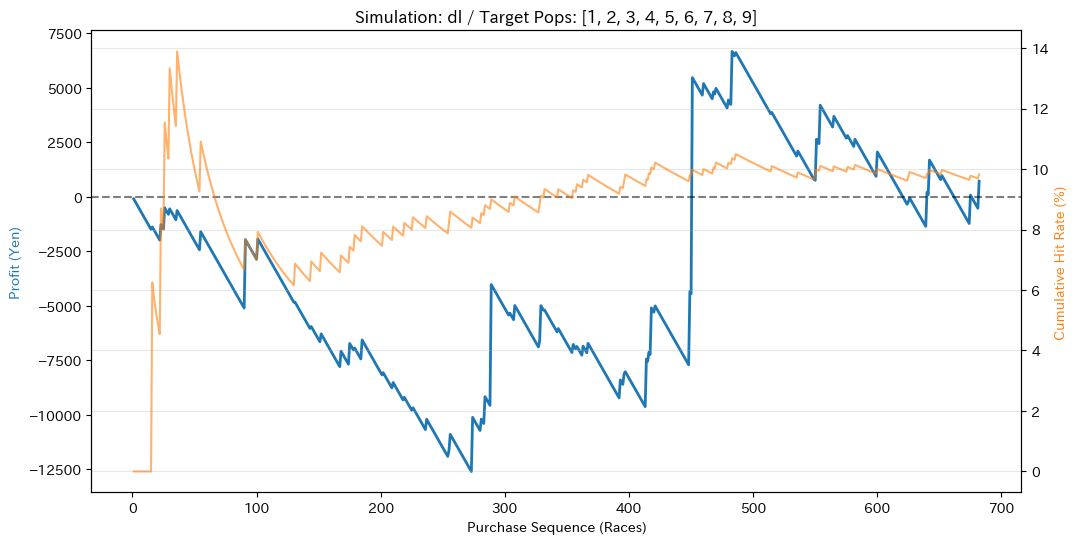


✅ 回収率: 101.04%
✅ 的中率: 9.82% (購入:682R / 全体:1684R)


In [35]:
# ===============================================================
# 🏇 設定変数（ここを調整してください）
# ===============================================================
PROB_SOURCE = "dl"
USE_STRICT_AGREEMENT = False
CANDIDATE_SELECT_BY = "win_prob"  # "win_prob" or "expected_value"
num_candidates = 9

# --- 【新設定】購入対象とする人気のリスト ---
# 例: [1, 2, 3] なら上位、[4, 5, 6, 7, 8] なら中穴など
TARGET_POPULARITIES = [1, 2, 3, 4, 5, 6, 7, 8, 9]

BET_STRATEGY = "edge"  # "dutching" or "edge"
AVOID_NEGATIVE_RETURN = True
RE_CALC_BY_EXCLUDING = True

# 8頭
EV_THRESHOLD_MAP = {
    1: 1.50,
    2: 2.00,
    3: 2.00,
    "default": 3.00
}

# 9頭
# EV_THRESHOLD_MAP = {
#     1: 1.50,
#     2: 2.00,
#     3: 2.00,
#     4: 2.00,
#     "default": 3.00
# }

# 10頭
# EV_THRESHOLD_MAP = {
#     1: 1.50,
#     2: 2.00,
#     3: 2.50,
#     4: 2.50,
#     "default": 3.00
# }

# ===============================================================
# 🏇 【最終工程】モンテカルロ・シミュレーション
# ===============================================================
import matplotlib.pyplot as plt

print("\n" + "="*70)
print(f"🚀 シミュレーション開始 [ターゲット人気: {TARGET_POPULARITIES}]")
print("="*70)

num_simulations = 1000
bet_total_limit = 100
all_unique_races = wf_all_xgb["race_id"].unique()
# 学習データを除外した真のテストデータのみを対象
target_races = all_unique_races[num_train_races:]
mc_bet_results = []
all_horses_log = []

for rid in tqdm(target_races, desc="Monte Carlo Simulating"):
    race_df = wf_all_xgb[wf_all_xgb["race_id"] == rid].copy()
    if len(race_df) == 0: continue
    
    # --- A/B. 優勝率・期待値算出 ---
    h_nums = race_df["horse_number"].values
    
    # XGB
    win_counts_xgb = {h: 0 for h in h_nums}
    probs_xgb = race_df["pred_prob_xgb"].values
    for _ in range(num_simulations):
        idx = np.argmax(probs_xgb + np.random.normal(0, 0.1, len(probs_xgb)))
        win_counts_xgb[h_nums[idx]] += 1
    race_df["ev_xgb"] = (race_df["horse_number"].map(win_counts_xgb) / num_simulations) * race_df["odds"]

    # DL
    win_counts_dl = {h: 0 for h in h_nums}
    probs_dl = race_df["pred_prob_dl"].values
    for _ in range(num_simulations):
        idx = np.argmax(probs_dl + np.random.normal(0, 0.1, len(probs_dl)))
        win_counts_dl[h_nums[idx]] += 1
    race_df["ev_dl"] = (race_df["horse_number"].map(win_counts_dl) / num_simulations) * race_df["odds"]

    # --- C. メイン指標の決定 ---
    if PROB_SOURCE == "xgb":
        race_df["expected_value"] = race_df["ev_xgb"]
        race_df["win_prob_sim"] = race_df["horse_number"].map(win_counts_xgb) / num_simulations
    elif PROB_SOURCE == "dl":
        race_df["expected_value"] = race_df["ev_dl"]
        race_df["win_prob_sim"] = race_df["horse_number"].map(win_counts_dl) / num_simulations
    else: # ensemble
        race_df["expected_value"] = (race_df["ev_xgb"] + race_df["ev_dl"]) / 2
        race_df["win_prob_sim"] = ((race_df["horse_number"].map(win_counts_xgb) + race_df["horse_number"].map(win_counts_dl)) / 2) / num_simulations

    # --- D. 購入候補選定 ---
    race_df["ev_threshold"] = race_df["popularity"].apply(lambda p: EV_THRESHOLD_MAP.get(p, EV_THRESHOLD_MAP["default"]))
    
    # 【改修点】期待値閾値 ＋ 人気リスト一致の判定
    mask = (race_df["expected_value"] > race_df["ev_threshold"]) & (race_df["popularity"].isin(TARGET_POPULARITIES))
    
    if USE_STRICT_AGREEMENT:
        mask = mask & (race_df["ev_xgb"] > 1.0) & (race_df["ev_dl"] > 1.0)
    
    sort_column = "win_prob_sim" if CANDIDATE_SELECT_BY == "win_prob" else "expected_value"
    ev_candidates = race_df[mask].sort_values(sort_column, ascending=False).head(num_candidates).copy()
    
    # --- E. 合成オッズ除外・資金配分 ---
    if not ev_candidates.empty and AVOID_NEGATIVE_RETURN:
        while not ev_candidates.empty:
            total_inv_odds = (1.0 / ev_candidates["odds"]).sum()
            if (1.0 / total_inv_odds) >= 1.0: break 
            if RE_CALC_BY_EXCLUDING:
                ev_candidates = ev_candidates.drop(ev_candidates["odds"].idxmin())
            else:
                ev_candidates = ev_candidates.iloc[0:0]; break

    race_df["is_purchased"] = False
    race_df["bet_amount"] = 0.0
    if not ev_candidates.empty:
        inv_odds = 1.0 / ev_candidates["odds"]
        if BET_STRATEGY == "dutching":
            amounts = (inv_odds / inv_odds.sum()) * bet_total_limit
        else: # edge
            edge = ev_candidates["expected_value"] - 1.0
            amounts = (edge / (edge.sum() if edge.sum() != 0 else 1)) * bet_total_limit
            
        for i, (idx, row) in enumerate(ev_candidates.iterrows()):
            race_df.loc[race_df["horse_number"] == row["horse_number"], ["is_purchased", "bet_amount"]] = [True, amounts.iloc[i]]

    race_df["payout"] = (race_df["finish_rank"] == 1).astype(int) * race_df["odds"] * race_df["bet_amount"]
    all_horses_log.append(race_df)
    if race_df["is_purchased"].any():
        mc_bet_results.append(race_df[race_df["is_purchased"]])

# --- 集計と可視化 ---
df_full_log = pd.concat(all_horses_log)
df_full_log.to_csv("C:\\Users\\ryo\\Downloads\\simulation_detail_log.csv", index=False, encoding="utf-8-sig")

if mc_bet_results:
    df_res = pd.concat(mc_bet_results)
    # レース単位の集計
    race_summary = df_res.groupby("race_id").agg({"bet_amount": "sum", "payout": "sum"}).reset_index()
    race_summary["cumulative_profit"] = (race_summary["payout"] - race_summary["bet_amount"]).cumsum()
    race_summary["hit_rate"] = ((race_summary["payout"] > 0).astype(int).cumsum() / (race_summary.index + 1)) * 100
    
    # グラフ表示
    fig, ax1 = plt.subplots(figsize=(12, 6))
    x = range(1, len(race_summary) + 1)
    
    ax1.plot(x, race_summary["cumulative_profit"], color="tab:blue", label="Cumulative Profit", linewidth=2)
    ax1.set_xlabel("Purchase Sequence (Races)")
    ax1.set_ylabel("Profit (Yen)", color="tab:blue")
    ax1.axhline(0, color='black', linestyle='--', alpha=0.5)
    
    ax2 = ax1.twinx()
    ax2.plot(x, race_summary["hit_rate"], color="tab:orange", label="Hit Rate", alpha=0.6)
    ax2.set_ylabel("Cumulative Hit Rate (%)", color="tab:orange")
    
    plt.title(f"Simulation: {PROB_SOURCE} / Target Pops: {TARGET_POPULARITIES}")
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"\n✅ 回収率: {df_res['payout'].sum() / df_res['bet_amount'].sum() * 100:.2f}%")
    print(f"✅ 的中率: {race_summary['hit_rate'].iloc[-1]:.2f}% (購入:{len(race_summary)}R / 全体:{len(target_races)}R)")
else:
    print("\n❌ 条件に合う馬が見つかりませんでした。")

In [36]:
# ===============================================================
# 📊 【改修版】戦略別・人気別成績レポート（独立出力形式）
# ===============================================================
print("\n" + "="*80)
print(f"📈 戦略評価レポート [設定: {BET_STRATEGY} / 除外設定: {AVOID_NEGATIVE_RETURN}]")
print("="*80)

# --- 1. 既存戦略（予測1位 1点買い）の人気別集計 ---
# ベースとするモデルを選択（シミュレーションのbase_probsと合わせてください）
df_base_model = wf_all_xgb.copy() 

# 各レースの予測1位を抽出
df_single_bet = df_base_model.loc[df_base_model.groupby("race_id")["pred_prob_xgb"].idxmax()].copy()
df_single_bet["is_hit"] = (df_single_bet["finish_rank"] == 1).astype(int)
df_single_bet["payout"] = df_single_bet["is_hit"] * df_single_bet["odds"] * 100 

single_pop_stats = df_single_bet.groupby("popularity").agg(
    count=("race_id", "count"),
    hits=("is_hit", "sum"),
    payout=("payout", "sum")
).reset_index()

single_pop_stats["的中率(%)"] = (single_pop_stats["hits"] / single_pop_stats["count"] * 100).round(2)
single_pop_stats["回収率(%)"] = (single_pop_stats["payout"] / (single_pop_stats["count"] * 100) * 100).round(2)

print(f"\n▼ 【戦略①：既存】予測1位 1点買い 人気別成績")
display_single = single_pop_stats[single_pop_stats["popularity"] <= 10].copy()
display_single.columns = ["人気", "購入レース数", "的中数", "払戻合計", "的中率(%)", "回収率(%)"]
print(display_single.to_string(index=False))


# --- 2. 新戦略（多点買い）の人気別集計 ---
if mc_bet_results:
    df_mc_strategy = pd.concat(mc_bet_results)
    
    mc_pop_stats = df_mc_strategy.groupby("popularity").agg(
        bet_count=("bet_amount", "count"),
        total_bet=("bet_amount", "sum"),
        hits=("payout", lambda x: (x > 0).sum()),
        total_payout=("payout", "sum")
    ).reset_index()

    mc_pop_stats["的中率(%)"] = (mc_pop_stats["hits"] / mc_pop_stats["bet_count"] * 100).round(2)
    mc_pop_stats["回収率(%)"] = (mc_pop_stats["total_payout"] / mc_pop_stats["total_bet"] * 100).round(2)

    print(f"\n▼ 【戦略②：新戦略】MC期待値 多点買い 人気別成績")
    display_mc = mc_pop_stats[mc_pop_stats["popularity"] <= 12].copy()
    display_mc.columns = ["人気", "購入票数", "投資合計", "的中数", "払戻合計", "的中率(%)", "回収率(%)"]
    print(display_mc.to_string(index=False))

    # --- 3. 全体比較サマリー ---
    print("\n" + "-"*50)
    print("🏁 全体比較サマリー")
    print("-"*50)

    total_invest_new = df_mc_strategy["bet_amount"].sum()
    total_return_new = df_mc_strategy["payout"].sum()
    hit_races_new = df_mc_strategy[df_mc_strategy["payout"] > 0]["race_id"].nunique()
    
    total_invest_old = df_single_bet["race_id"].count() * 100
    total_return_old = df_single_bet["payout"].sum()
    hit_races_old = df_single_bet["is_hit"].sum()
    total_target_races = len(target_races)

    summary_data = {
        "指標": ["対象レース数", "的中レース数", "的中率(R単位)", "総投資額", "総払戻額", "最終回収率"],
        "既存(1点買)": [f"{total_target_races}R", f"{hit_races_old}R", f"{hit_races_old/total_target_races*100:.2f}%", f"{total_invest_old:,.0f}円", f"{total_return_old:,.0f}円", f"{total_return_old/total_invest_old*100:.2f}%"],
        "新戦略(多点)": [f"{total_target_races}R", f"{hit_races_new}R", f"{hit_races_new/total_target_races*100:.2f}%", f"{total_invest_new:,.0f}円", f"{total_return_new:,.0f}円", f"{total_return_new/total_invest_new*100:.2f}%"]
    }
    print(pd.DataFrame(summary_data).to_string(index=False))

    if BET_STRATEGY == "dutching":
        race_summary = df_mc_strategy.groupby("race_id").agg(total_bet=("bet_amount", "sum"), total_payout=("payout", "sum"))
        avg_comp_odds = (race_summary[race_summary["total_payout"] > 0]["total_payout"] / race_summary[race_summary["total_payout"] > 0]["total_bet"]).mean()
        print(f"\n💡 的中時の平均合成オッズ: {avg_comp_odds:.2f}倍")

else:
    print("\n⚠ 新戦略での購入データがありません。")


📈 戦略評価レポート [設定: edge / 除外設定: True]

▼ 【戦略①：既存】予測1位 1点買い 人気別成績
 人気  購入レース数  的中数    払戻合計  的中率(%)  回収率(%)
1.0    1151  594 90980.0   51.61   79.04
2.0     532  129 41340.0   24.25   77.71
3.0     260   35 16710.0   13.46   64.27
4.0     129   11  7870.0    8.53   61.01
5.0      44    5  5330.0   11.36  121.14
6.0      27    1  1980.0    3.70   73.33
7.0       5    0     0.0    0.00    0.00
8.0       3    0     0.0    0.00    0.00

▼ 【戦略②：新戦略】MC期待値 多点買い 人気別成績
 人気  購入票数         投資合計  的中数         払戻合計  的中率(%)  回収率(%)
1.0    47  4294.202300   12  2639.544585   25.53   61.47
2.0    80  6599.208417   15  6919.704518   18.75  104.86
3.0   180 13859.478980   16  8776.855704    8.89   63.33
4.0    73  5892.048381    6  5051.678341    8.22   85.74
5.0   117  9051.045713    6 13607.378470    5.13  150.34
6.0   127 10417.157323    7 14817.124748    5.51  142.24
7.0   129 10474.992704    3 13302.323601    2.33  126.99
8.0    97  7611.866182    2  3796.491093    2.06   49.88

-------------------------